In [2]:
import pandas as pd

# read in all data
test = pd.read_csv('../data/test.txt', delimiter=';', names=['text', 'target'])
train = pd.read_csv('../data/train.txt', delimiter=';',
                    names=['text', 'target'])
val = pd.read_csv('../data/val.txt', delimiter=';', names=['text', 'target'])
trainval = pd.concat([train,val])
testval = pd.concat([test,val])

In [ ]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

# create vectorier for BoW
vectorizer = CountVectorizer(max_df=0.9,min_df=5,stop_words='english',ngram_range=(1,1))
BoW = vectorizer.fit_transform(trainval.text)
print('Number of Features in BoW: ',len(vectorizer.get_feature_names()))

X_trainval = vectorizer.transform(trainval.text).toarray()
Y_trainval = trainval.target
X_train = vectorizer.transform(train.text).toarray()
Y_train = train.target
X_val = vectorizer.transform(val.text).toarray()
Y_val = val.target
X_test = vectorizer.transform(test.text).toarray()
Y_test = test.target


In [ ]:
""" from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
import numpy as np

C_array = np.array([0.1, 1, 5])
Gamma_array = np.array([0.1, 1, 5])
best_C = 0; best_gamma = 0
best_acc = 0
best_model = None

for C in C_array:
    for gamma in Gamma_array:
        model = SVC(C=C, gamma=gamma, kernel='rbf', decision_function_shape='ovr', class_weight='balanced')
        score = cross_val_score(model, X_trainval, Y_trainval, cv=3)
        print(f'C = {C}, gamma = {gamma}, score = {score}')
        if best_acc < score.mean():
            best_C = C
            best_gamma = gamma
            best_acc = score.mean()
            best_model = model

Y_test_pred = best_model.predict(X_test)
#train_acc = model.score(X_train, Y_train)
#test_acc = model.score(X_test, Y_test)

#print('Train Accuracy: {:.4}'.format(train_acc))
#print('Test Accuracy: {:.4}'.format(test_acc)) """


In [ ]:
import sklearn.metrics as skm

print(skm.classification_report(Y_test, Y_test_pred))
pd.DataFrame(skm.confusion_matrix(Y_test, Y_test_pred),
             columns=['anger', 'fear', 'joy', 'love', 'sadness', 'surprise'],
             index=['anger', 'fear', 'joy', 'love', 'sadness', 'surprise'])


## Bagging Classification with DT

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
import sklearn.metrics as skm

bag = BaggingClassifier(n_estimators=10, random_state=0)
bag.fit(X_train, Y_train)
Y_test_pred = bag.predict(X_test)

train_acc = bag.score(X_train, Y_train)
test_acc = bag.score(X_test, Y_test)


In [ ]:
# get metrics

print('---------------- Bagging Statistics ----------------')
print('Train Accuracy: {:.4}'.format(train_acc))
print('Test Accuracy: {:.4}'.format(test_acc))
print(skm.classification_report(Y_test, Y_test_pred))
pd.DataFrame(skm.confusion_matrix(Y_test, Y_test_pred), 
    columns=['anger', 'fear', 'joy', 'love', 'sadness', 'surprise'],
             index=['anger', 'fear', 'joy', 'love', 'sadness', 'surprise'])


## Random Forest with DT

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as skm

rf = RandomForestClassifier(n_estimators=10, random_state=0)
rf.fit(X_train, Y_train)
Y_test_pred = rf.predict(X_test)

train_acc = rf.score(X_train, Y_train)
test_acc = rf.score(X_test, Y_test)


In [ ]:
print('------------- Random Forest Statistics -------------')
print('Train Accuracy: {:.4}'.format(train_acc))
print('Test Accuracy: {:.4}'.format(test_acc))
print(skm.classification_report(Y_test, Y_test_pred))
pd.DataFrame(skm.confusion_matrix(Y_test, Y_test_pred),
             columns=['anger', 'fear', 'joy', 'love', 'sadness', 'surprise'],
             index=['anger', 'fear', 'joy', 'love', 'sadness', 'surprise'])

## AdaBoost Classification with DT

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
import sklearn.metrics as skm

ada = AdaBoostClassifier(n_estimators=1000, random_state=0)
ada.fit(X_train, Y_train)
Y_test_pred = ada.predict(X_test)

train_acc = ada.score(X_train, Y_train)
test_acc = ada.score(X_test, Y_test)


In [ ]:

print('---------------- AdaBoost Statistics ----------------')
print('Train Accuracy: {:.4}'.format(train_acc))
print('Test Accuracy: {:.4}'.format(test_acc))
print(skm.classification_report(Y_test, Y_test_pred))
pd.DataFrame(skm.confusion_matrix(Y_test, Y_test_pred),
             columns=['anger', 'fear', 'joy', 'love', 'sadness', 'surprise'],
             index=['anger', 'fear', 'joy', 'love', 'sadness', 'surprise'])


## Detailed Analysis and Fine Tuning 
**Random Forrest** showed the most promising initial results. In this section we fine tune parameters and perform additional evaluation of the model and its performance.

### BoW Generation and Dataset Transformation
We duplicate here from above for additional testing and tuning if required.

In [4]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder

# create vectorier for BoW
vectorizer = CountVectorizer(max_df=0.9, min_df=5, stop_words='english', ngram_range=(1, 1))
BoW = vectorizer.fit_transform(trainval.text)
print('Number of Features in BoW: ', len(vectorizer.get_feature_names_out()))

enc = LabelEncoder().fit(['anger', 'fear', 'joy', 'love', 'sadness', 'surprise'])

# transform all the data
X_trainval = vectorizer.transform(trainval.text).toarray()
Y_trainval = enc.transform(trainval.target)
X_train = vectorizer.transform(train.text).toarray()
Y_train = enc.transform(train.target)
X_val = vectorizer.transform(val.text).toarray()
Y_val = enc.transform(val.target)
X_test = vectorizer.transform(test.text).toarray()
Y_test = enc.transform(test.target)




Number of Features in BoW:  3398


### Multiclass ROC Curve Function
Function to generate a multiclass ROC plot. We'll use this for further evaluation.

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from itertools import cycle
from sklearn.metrics import RocCurveDisplay

classes = ['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']

def plot_mc_roc(Y_test_bin, Y_test_proba, n_classes, title='ROC Curve'):
    ax = plt.axes()
    leg = []
    for i in range(n_classes):
        y_score = Y_test_proba[:, i]
        fpr, tpr, _ = roc_curve(Y_test_bin[:, i], y_score)
        roc_auc = auc(fpr, tpr)
        leg.append(classes[i] + ' (auc = {:.4})'.format(roc_auc))
        RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax)

    plt.xlim((0, .4))
    plt.ylim((.6, 1))
    plt.legend(leg)
    plt.title(title)


In [6]:
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as skm
import matplotlib.pyplot as plt

rf = RandomForestClassifier(n_estimators=10, random_state=0)
rf.fit(X_trainval, Y_trainval)
Y_test_pred = rf.predict(X_test)
print(skm.classification_report(Y_test, Y_test_pred))
pd.DataFrame(skm.confusion_matrix(Y_test, Y_test_pred),columns=classes, index=classes)

              precision    recall  f1-score   support

           0       0.89      0.90      0.89       275
           1       0.84      0.85      0.85       224
           2       0.91      0.88      0.90       695
           3       0.73      0.75      0.74       159
           4       0.92      0.92      0.92       581
           5       0.62      0.73      0.67        66

    accuracy                           0.88      2000
   macro avg       0.82      0.84      0.83      2000
weighted avg       0.88      0.88      0.88      2000



,anger,fear,joy,love,sadness,surprise
anger,247,11,5,1,10,1
fear,8,191,0,1,10,14
joy,5,6,614,35,24,11
love,2,0,35,119,1,2
sadness,15,10,13,6,535,2
surprise,1,9,6,0,2,48


**plot ROC curve for un-tuned Random Forrest Classifier**

NameError: name 'RocCurveDisplay' is not defined

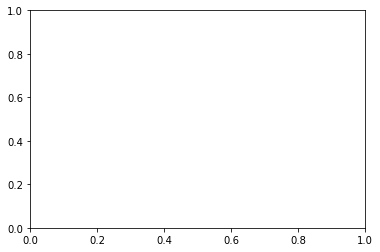

In [7]:
from sklearn.preprocessing import label_binarize

Y_test_bin = label_binarize(Y_test, classes=[0, 1, 2, 3, 4, 5])
Y_test_proba = rf.predict_proba(X_test)
plot_mc_roc(Y_test_bin, Y_test_proba, n_classes=6, title='ROC for un-tuned Random Forrest (one-vs-all)')

### N-Estimators Evaluation
Evaluating random forrest performance as the number of estimator trees is changed.

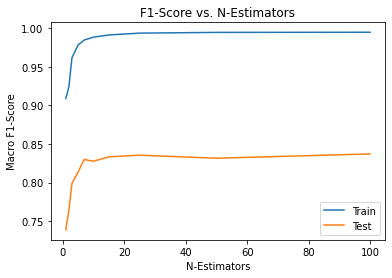

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

train_F1 = []
test_F1 = []
ne_samps = [1, 2, 3, 5, 7, 10, 15, 25, 50, 100]
for ne in ne_samps:
    rf = RandomForestClassifier(n_estimators=ne, random_state=0)
    rf.fit(X_trainval, Y_trainval)
    Y_test_pred = rf.predict(X_test)
    Y_train_pred = rf.predict(X_trainval)
    train_F1.append(f1_score(Y_trainval, Y_train_pred, average='macro'))
    test_F1.append(f1_score(Y_test, Y_test_pred, average='macro'))

plt.xlabel('N-Estimators')
plt.ylabel('Macro F1-Score')
plt.title('F1-Score vs. N-Estimators')
plt.plot(ne_samps, train_F1)
plt.plot(ne_samps, test_F1)
plt.legend(['Train','Test'])

### Max Features Evaluation

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

train_F1 = []
test_F1 = []
mf_samps = [1, 5, 10, 25, 50, 100, 150, 200]
for mf in mf_samps:
    rf = RandomForestClassifier(n_estimators=25, max_features=mf, random_state=0)
    rf.fit(X_trainval, Y_trainval)
    Y_test_pred = rf.predict(X_test)
    Y_train_pred = rf.predict(X_trainval)
    train_F1.append(f1_score(Y_trainval, Y_train_pred, average='macro'))
    test_F1.append(f1_score(Y_test, Y_test_pred, average='macro'))

plt.xlabel('N-Estimators')
plt.ylabel('Macro F1-Score')
plt.title('F1-Score vs. N-Estimators')
plt.plot(mf_samps, train_F1)
plt.plot(mf_samps, test_F1)
plt.legend(['Train', 'Test'])
